In [1]:
import numpy as np
import cvxpy as cp
from matplotlib import pyplot as plt
from scipy.linalg import fractional_matrix_power
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

Let's  try to reproduce the idea of [this paper](http://faculty.olin.edu/dshuman/Papers/Conference/Thanou_et_al_GlobalSIP_2013.pdf).
In particular we are going to define a dictionary composed of $S$ subdictionaries, each of them parametrized as a polynomial of the laplacian: 

$$
D_s = \sum_{k = 0}^K \alpha_{sk} \mathcal{L}^k, \ s = 1,...,S
$$

this dictionary has the structure of a convolutional filter bank, and by looking at the spectrum of each subdictionary we find out that each atom of each subdictionary has a localization quality over a node $v \in V$.

Assuming a graph $G(V,E)$, and a set of $N$ observed signals $Y \in \mathbb{R}^{V \times N}$, we have the following optimization problem:

$$
\begin{cases}
\underset{X,D}{\mathrm{min}} & ||Y -DX||_F^2 + \lambda ||X||_{:,1}\\
& D_s = \sum_{k = 0}^K \alpha_{sk} \mathcal{L}^k, & s = 1,...,S \\
& 0 \preceq D_s \preceq k\mathbb{I}, & s = 1,...,S \\
& (c - \epsilon) \mathbb{I} \preceq \sum_{s=1}^S D_s \preceq (c + \epsilon)\mathbb{I}

\end{cases}
$$

where the constraints are meant to grant that the spectrum of each filter and of the over all dictionary meaningfully covers the representations of the signals. 

The problem can be solved alternating the optimization of $D$, i.e. of its parametrization, and of the sparse coding $X$ of each 0-cochain.

### Building the graph

In [2]:
N = 80
cutoff = 0.5
theta = 0.9

points = np.random.rand(N, 2)

In [3]:
def GaussianKernel(P1, P2, theta):

    return np.exp(- np.linalg.norm(P1 - P2)**2/(2*theta**2))

In [4]:
A = np.zeros((N,N))
W = np.zeros((N,N))

for i in range(N):
    for j in range(i, N):
        
        A[i,j] = np.linalg.norm(points[i,:] - points[j,:]) <= cutoff
        A[j,i] = np.linalg.norm(points[i,:] - points[j,:]) <= cutoff

In [5]:
D = np.diag(np.sum(A, axis = 1))

In [6]:
L = D - A
L = fractional_matrix_power(D, -0.5) @ L @ fractional_matrix_power(D, -0.5)

### Define a band-localized overcomplete dictionary

In [7]:
band1 = np.array([i in range(0,20) for i in range(80)])
band2 = np.array([i in range(20,30) for i in range(80)]) + np.array([i in range(70,80) for i in range(80)])
band3 = np.array([i in range(30,50) for i in range(80)])
band4 = np.array([i in range(50,70) for i in range(80)])

bands = [band1, band2, band3, band4]

In [8]:
Lambda, U = np.linalg.eig(L)
Lambda = np.sort(Lambda)

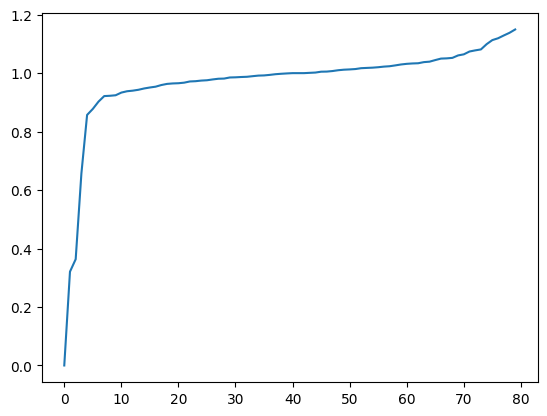

In [9]:
plt.plot(Lambda)

In [10]:
J = 320
DD = np.zeros((N, J))

In [11]:
for j in range(J): 

    B = j // 80
    h = np.copy(Lambda)
    h[~bands[B]] = 0
    h *= np.random.rand(h.shape[0],1)[:,0]
    n = np.random.choice(N)

    DD[:,j] = (U @ np.diag(h) @ U.T)[:,n]

In [12]:
D1 = DD[:,range(0,80)]
D2 = DD[:,range(80,160)]
D3 = DD[:,range(160,240)]
D4 = DD[:,range(240,320)]

### Define the signals 

In [13]:
M = 1000 
Y_train = np.zeros((N,M))

for m in range(M):
    T = np.random.choice(J, 4)
    Y_train[:,m] = DD[:,T] @ np.random.rand(4)

test_size = 2000
Y_test = np.zeros((N,test_size))

for t in range(test_size):
    T = np.random.choice(J, 4)
    Y_test[:,t] = DD[:,T] @ np.random.rand(4)

### Dictionary learning algorithm 

In [14]:
c = 1
eps = 0.01

T0 = 4
S = 4
K = 20

In [15]:
# Subroutine for sparse coding

def OMP(y, D, T0):
    S = []

    x = np.zeros(D.shape[1])
    iters = 0
    R = y

    while iters < T0:

        # Retrieve the maximum correlation between atoms and residuals of the previous iteration
        S.append(np.argmax(np.abs(D.T @ R)))

        # Expand the dictionary for the representation
        dic = D[:,S]

        # Solve subproblems and update x
        x[S] = np.linalg.inv(dic.T @ dic) @ dic.T @ y
        
        # Update the residuals
        R = y - D @ x
        iters += 1

    return x

In [16]:
# Dictionary update subroutine

def LaplacianPowers(L, K):
    powers = np.zeros((K+1, L.shape[0], L.shape[1]))
    for k in range(K+1):
        powers[k,:,:] = np.linalg.matrix_power(L, k)

    return powers 

def DicUp(LaplPowers, K, S, Y, X, N, c, eps, mu = 1):
    # Variables
    alpha = cp.Variable((K+1, S))

    # Define D_s expressions
    D_s_list = []
    for s in range(S):
        D_s = sum(alpha[k, s] * LaplPowers[k,:,:] for k in range(K+1))
        D_s_list.append(D_s)

    # Objective function
    D = cp.hstack(D_s_list)
    objective = cp.Minimize(cp.norm(Y - D @ X, 'fro')**2 + mu * cp.norm(alpha, 2)**2)

    # Constraints
    constraints = []
    for s in range(S):
        constraints.append(D_s_list[s] >> 0)
        constraints.append(D_s_list[s] << c * np.eye(N))

    sum_D_s = sum(D_s_list)
    constraints.append(sum_D_s >> (c - eps) * np.eye(N))
    constraints.append(sum_D_s << (c + eps) * np.eye(N))

    # Problem definition and solving
    prob = cp.Problem(objective, constraints)
    prob.solve(solver=cp.SCS, max_iters=100, eps=1e-5, warm_start=True)

    alpha_star = alpha.value
    D_s_list = []
    for s in range(S):
        D_s = sum(alpha_star[k, s] * LaplPowers[k,:,:] for k in range(K+1))
        D_s_list.append(D_s)

    # Objective function
    D = np.hstack(D_s_list)
    return D

In [15]:
# Parametric dictionary learning algorithm 

def ParametricDictionaryLearning(Y, T0, K, S, N, M, c, eps, mu = 1, MAX_ITER = 50):

    loss = []

    # Precompute Laplacian powers
    LP = LaplacianPowers(L, K)

    # Dictionary initialization 
    D_s_list = []
    for _ in range(S):
        D_s = sum(LP[k,:,:] for k in range(K+1))
        D_s_list.append(D_s)

    D = np.hstack(D_s_list)

    # Alternated learning procedure
    for _ in tqdm(range(MAX_ITER)):
        
        # Sparse coding update
        X = np.apply_along_axis(OMP, axis = 0, arr = Y, D = D, T0 = T0)

        # Dictionary update
        D = DicUp(LP, K, S, Y, X, N, c, eps, mu)
        D = np.apply_along_axis(lambda x: x / np.linalg.norm(x), axis = 0, arr = D)

        loss.append(np.linalg.norm(Y - D @ X, ord = 'fro'))
        
    return D, loss

In [18]:
D, loss = ParametricDictionaryLearning(Y_train, T0, K, S, N, M, c, eps)

100%|██████████| 50/50 [07:11<00:00,  8.64s/it]


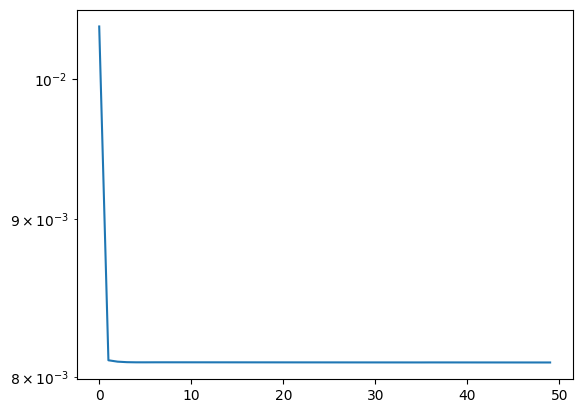

In [19]:
plt.plot([ L / M for L in loss ])
plt.yscale('log')